# FWI 

In [1]:
import numpy as np
from jax import jit, vjp, vmap, pmap
import jax
from jax import numpy as jnp
from jax import random
from matplotlib import pyplot as plt


from jwave.geometry import Domain, Medium
from jwave.utils import display_complex_field

key = random.PRNGKey(42)  # Random seed


from hybridoed.forward import create_src_field
from hybridoed.oed import *

from functools import partial

import numpy as np
from jax import grad, jit, lax, nn
from jax import numpy as jnp
from jax import random, value_and_grad, vmap
from jax.example_libraries import optimizers
from matplotlib import pyplot as plt
from tqdm import tqdm

from jwave import FourierSeries
from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import (
    Domain,
    Medium,
    Sensors,
    Sources,
    TimeAxis,
    circ_mask,
    points_on_circle,
)
from jwave.signal_processing import apply_ramp, gaussian_window, smooth

(500, 1, 70, 70)


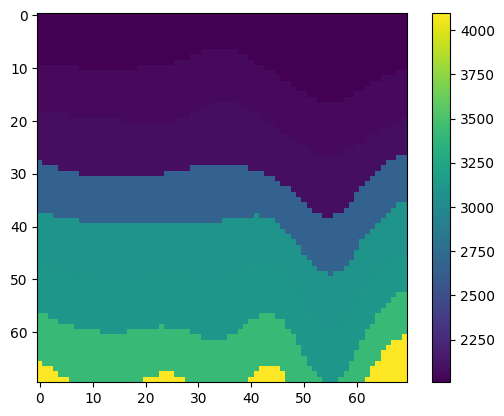

<class 'jaxlib.xla_extension.ArrayImpl'>


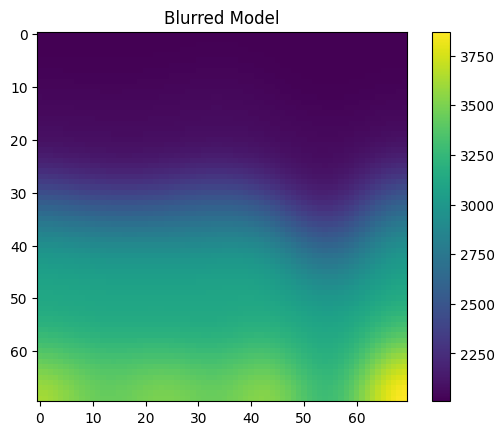

(70, 70)


In [63]:
model = jnp.load('model1.npy')
print(model.shape)

true_model = model[7,0,:,:]
plt.imshow(true_model)
plt.colorbar()
plt.show()
print(type(true_model))

from scipy.ndimage import gaussian_filter

# Apply a Gaussian blur
# Adjust sigma as needed; larger sigma = more blur
blurred_model = gaussian_filter(true_model, sigma=5)

# Visualize the blurred model
plt.figure()
plt.imshow(blurred_model, cmap='viridis')
plt.colorbar()
plt.title('Blurred Model')
plt.show()
print(blurred_model.shape)


In [41]:
N = (70, 70)  # Grid size
dx = (1.0, 1.0)  # Spatial resolution
cfl=0.25

# Defining the domain
domain = Domain(N, dx)

source_freq = 100
source_mag = 1.3e-1

medium = Medium(domain=domain, sound_speed=true_model, density=1000., pml_size=10)

# Time axis
time_axis = TimeAxis.from_medium(medium, cfl=cfl)
t = time_axis.to_array()
source_mag = source_mag / time_axis.dt

s1 = source_mag * jnp.sin(2 * jnp.pi * source_freq * t + 100)
signal = gaussian_window(apply_ramp(s1, time_axis.dt, source_freq), t, 0.5e-2, 1e-2)




src_coords_list = jnp.array([
    [60.1, 16.1],
    [60.1, 24.1],
    [60.1, 32.1],
    [60.1, 40.1],
    [60.1, 48.1],
]  ).astype(jnp.int32)

receiver_coords_list = jnp.array([
    [8.1, 0.125 * N[1] + 0.1],
    [8.1, 0.25 * N[1] + 0.1],
    [8.1, 0.5 * N[1] + 0.1],
    [8.1, 0.75 * N[1] + 0.1],
    [8.1, 0.9 * N[1] + 0.1],
]).astype(jnp.int32)

num_sources = src_coords_list.shape[0]
sensors_positions = (receiver_coords_list[:,0],receiver_coords_list[:,1])
sensors = Sensors(positions=sensors_positions)
source_positions = (src_coords_list[:,0],src_coords_list[:,1])

print(sensors_positions)

(Array([8, 8, 8, 8, 8], dtype=int32), Array([ 8, 17, 35, 52, 63], dtype=int32))


Text(0.5, 1.0, 'Source signals')

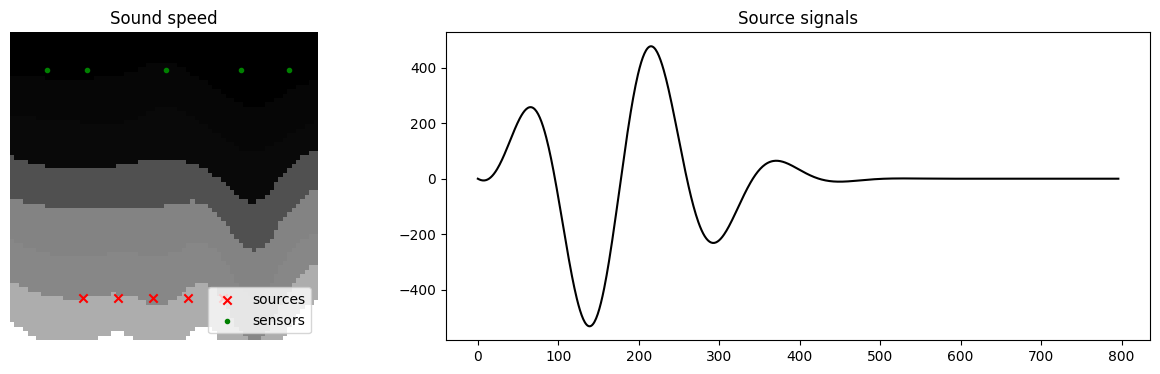

In [42]:

 # Show simulation setup
fig, ax = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={"width_ratios": [1, 2]})

ax[0].imshow(medium.sound_speed.on_grid, cmap="gray")
ax[0].scatter(
    source_positions[1], source_positions[0], c="r", marker="x", label="sources"
)
ax[0].scatter(
    sensors_positions[1], sensors_positions[0], c="g", marker=".", label="sensors"
)
ax[0].legend(loc="lower right")
ax[0].set_title("Sound speed")
ax[0].axis("off")

ax[1].plot(signal, label="Source 1", c="k")
ax[1].set_title("Source signals")
#ax[1].get_yaxis().set_visible(False)

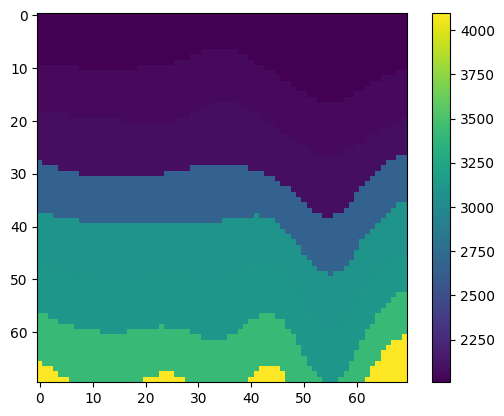

In [43]:
plt.imshow(medium.sound_speed.on_grid)
plt.colorbar()

In [44]:
src_signal = jnp.stack([signal])

# We can compile the entire function! All the constructors
# that don't depend on the inputs will be statically compiled
# and run only once.
@jit
def single_source_simulation(sound_speed, source_num):
    # Setting source
    x = lax.dynamic_slice(source_positions[0], (source_num,), (1,))
    y = lax.dynamic_slice(source_positions[1], (source_num,), (1,))
    sources = Sources((x, y), src_signal, dt=time_axis.dt, domain=domain)

    # Updating medium with the input speed of sound map
    medium = Medium(domain=domain, sound_speed=sound_speed, pml_size=20)

    # Run simulations
    rf_signals = simulate_wave_propagation(
        medium, time_axis, sources=sources, sensors=sensors, checkpoint=True
    )
    return rf_signals[..., 0]

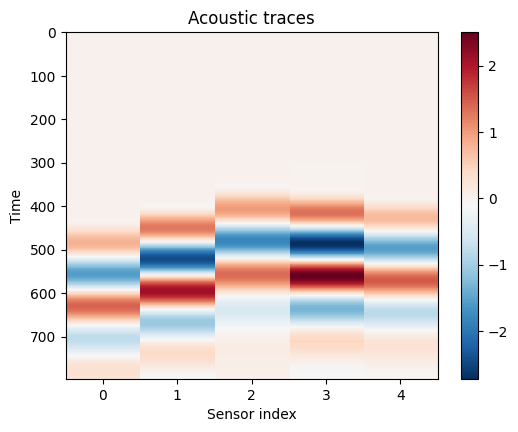

In [45]:
p = single_source_simulation(medium.sound_speed, 20)

# Visualize the acoustic traces
plt.figure(figsize=(6, 4.5))
maxval = jnp.amax(jnp.abs(p))
plt.imshow(
    p, cmap="RdBu_r", interpolation="nearest", aspect="auto"
)
plt.colorbar()
plt.title("Acoustic traces")
plt.xlabel("Sensor index")
plt.ylabel("Time")
plt.show()

In [46]:
%%timeit
single_source_simulation(medium.sound_speed, 1).block_until_ready()

104 ms ± 377 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [56]:
batch_simulations = vmap(single_source_simulation, in_axes=(None, 0))
p_data = batch_simulations(medium.sound_speed, jnp.arange(num_sources))
print(f"Size of data [Source idx, Time, Sensor idx]: {p_data.shape}")

Size of data [Source idx, Time, Sensor idx]: (5, 797, 5)


In [37]:
%%timeit
batch_simulations(medium.sound_speed, jnp.arange(num_sources)).block_until_ready()

538 ms ± 6.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


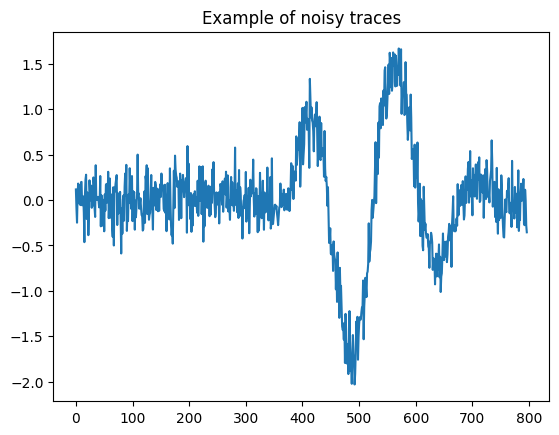

In [ ]:
# p_data = batch_simulations(medium.sound_speed, jnp.arange(num_sources))
# noise = np.random.normal(size=p_data.shape) * 0.2
# noise = jnp.fft.fft(noise, axis=1)
# #noise = noise.at[:, 100:-100].set(0.0)
# noise = jnp.fft.ifft(noise, axis=1).real
# p_data = p_data + noise

# plt.plot(p_data[1, :, 0])
# plt.title("Example of noisy traces")
# plt.show()

In [77]:
from jaxdf.operators import compose

mask = circ_mask(domain.N, 80, (128, 128))
mask = FourierSeries(jnp.expand_dims(mask, -1), domain)

def get_sound_speed(params):
    return params

# initial model is the blurred model
params = blurred_model
# params = medium.sound_speed * 0.1 + 
params

array([[2011.2123, 2011.1997, 2011.1748, ..., 2009.7905, 2009.8284,
        2009.8479],
       [2011.636 , 2011.6217, 2011.5934, ..., 2009.9899, 2010.0359,
        2010.0597],
       [2012.5009, 2012.4833, 2012.4485, ..., 2010.409 , 2010.4717,
        2010.504 ],
       ...,
       [3591.7517, 3586.2012, 3575.573 , ..., 3804.7566, 3829.0605,
        3841.493 ],
       [3608.0195, 3602.1602, 3590.9414, ..., 3823.3784, 3848.0051,
        3860.596 ],
       [3616.435 , 3610.4119, 3598.8801, ..., 3832.8677, 3857.6516,
        3870.3193]], dtype=float32)

In [78]:
from jwave.signal_processing import analytic_signal
from jaxdf.operators import gradient, functional

def hilbert_transf(signal, noise=0.2):
    x = jnp.abs(analytic_signal(signal))
    return x

def loss_func(params, source_num):
    c0 = get_sound_speed(params)
    p = single_source_simulation(c0, source_num)
    data = p_data[source_num]
    return jnp.mean(jnp.abs(hilbert_transf(p) -hilbert_transf(data)) ** 2)

loss_with_grad = value_and_grad(loss_func, argnums=0)

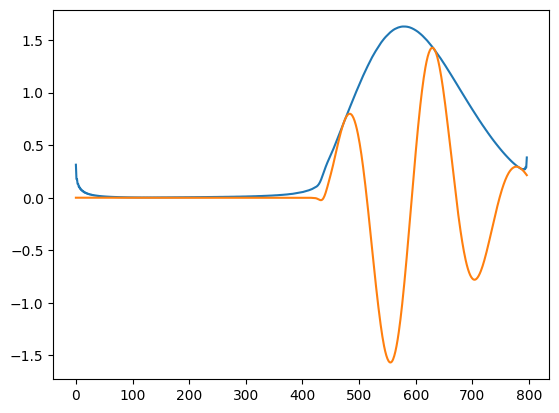

In [79]:
plt.plot(hilbert_transf(p_data[12, :, 0]))
plt.plot(p_data[12, :, 0])
plt.show()

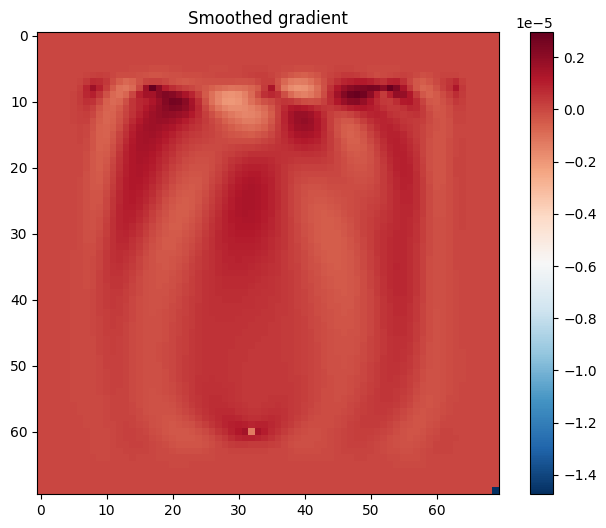

In [81]:
def smooth_fun(gradient):
    x = gradient.on_grid[..., 0]
    for _ in range(3):
        x = smooth(x)
    return gradient.replace_params(jnp.expand_dims(x, -1))*6

loss, gradient = loss_with_grad(params, source_num=2)
# gradient = smooth_fun(gradient)

# Viualize
plt.figure(figsize=(8, 6))
plt.imshow(gradient, cmap="RdBu_r")
plt.title("Smoothed gradient")
plt.colorbar()
plt.show()

In [90]:
losshistory = []
reconstructions = []
num_steps = 1000

# Define optimizer
init_fun, update_fun, get_params = optimizers.adam(0.1, 0.9, 0.9)
opt_state = init_fun(params)

# Define and compile the update function
@jit
def update(opt_state, key, k):
    v = get_params(opt_state)
    src_num = random.choice(key, num_sources)
    lossval, gradient = loss_with_grad(v, src_num)
    # gradient = smooth_fun(gradient)
    return lossval, update_fun(k, gradient, opt_state)


# Main loop
pbar = tqdm(range(num_steps))
_, key = random.split(key)
for k in pbar:
    _, key = random.split(key)
    lossval, opt_state = update(opt_state, key, k)

    ## For logging
    new_params = get_params(opt_state)
    reconstructions.append(get_sound_speed(new_params))
    losshistory.append(lossval)
    pbar.set_description("Loss: {}".format(lossval))

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: 0.0006664686370640993: 100%|██████████| 1000/1000 [05:54<00:00,  2.82it/s]


In [86]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

/var/folders/yk/cm5r1cbs3bxd7jcf31625bxc0000gn/T/ipykernel_81998/3865871844.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


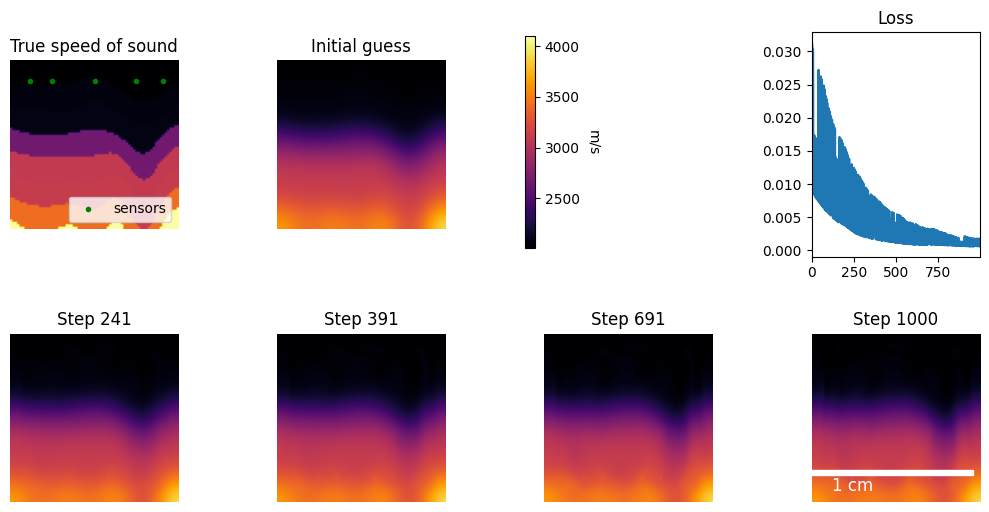

In [91]:
sos_original = get_sound_speed(params)
true_sos = true_model
vmin = np.amin(true_sos)
vmax = np.amax(true_sos)

fig, axes = plt.subplots(2, 4, figsize=(10, 5.5))

k = 0
recs = [240, 390, 690, 999]
for row in range(2):
    for col in range(4):
        if k == 0:
            axes[row, col].imshow(true_sos, cmap="inferno", vmin=vmin, vmax=vmax)
            axes[row, col].scatter(
                sensors_positions[1],
                sensors_positions[0],
                c="g",
                marker=".",
                label="sensors",
            )
            axes[row, col].legend(loc="lower right")
            axes[row, col].set_title("True speed of sound")
            axes[row, col].set_axis_off()
        elif k == 1:
            im_original = axes[row, col].imshow(sos_original, cmap="inferno", vmin=vmin, vmax=vmax)
            axes[row, col].set_axis_off()
            axes[row, col].set_title("Initial guess")
            
            cbar_ax = fig.add_axes([0.53, 0.54, 0.01, 0.385])
            cbar = plt.colorbar(im_original, cax=cbar_ax)
            cbar.ax.get_yaxis().labelpad = 15
            cbar.ax.set_ylabel('m/s', rotation=270)
        elif k == 2:
            axes[row, col].set_axis_off()
        elif k == 3:
            axes[row, col].plot(losshistory)
            axes[row, col].set_title("Loss")
            #axes[row, col].set_xticks([], [])
            axes[row, col].margins(x=0)
        else:
            axes[row, col].imshow(reconstructions[recs[k - 4]], cmap="inferno", vmin=vmin, vmax=vmax)
            axes[row, col].set_axis_off()
            axes[row, col].set_title("Step {}".format(recs[k - 4] + 1))
        k += 1

# Scale bar
fontprops = fm.FontProperties(size=12)
scalebar = AnchoredSizeBar(
    axes[-1, -1].transData,
    100, '1 cm', 'lower right', 
    pad=0.3,
    color='white',
    frameon=False,
    size_vertical=2,
    fontproperties=fontprops)
axes[-1, -1].add_artist(scalebar)
        
fig.tight_layout()

plt.savefig('fwi.pdf')

In [92]:
reconstructions[0] - reconstructions[-1]

Array([[  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
        -54.104492]], dtype=float32)